In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [13]:
import argparse
import logging
import math
import os
import random
from pathlib import Path

import accelerate
import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.utils import ContextManagers

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, deprecate, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

In [14]:
# fix the bug - assert "source" in options and options["source"] is not None
# reference: https://github.com/d8ahazard/sd_dreambooth_extension/pull/1186
if os.name == "posix":
    # For now disable Torch2 Dynamo
    os.environ["TORCHDYNAMO_DISABLE"] = "1"

if is_wandb_available():
    import wandb

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.17.0.dev0")


logger = get_logger(__name__, log_level="INFO")

DATASET_NAME_MAPPING = {
    "lambdalabs/pokemon-blip-captions": ("image", "text"),
}

In [15]:
def log_validation(vae, text_encoder, tokenizer, unet, args, accelerator, weight_dtype, epoch):
    logger.info("Running validation... ")

    pipeline = StableDiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        vae=accelerator.unwrap_model(vae),
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=accelerator.unwrap_model(unet),
        safety_checker=None,
        revision=args.revision,
        torch_dtype=weight_dtype,
    )
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    if args.enable_xformers_memory_efficient_attention:
        pipeline.enable_xformers_memory_efficient_attention()

    if args.seed is None:
        generator = None
    else:
        generator = torch.Generator(device=accelerator.device).manual_seed(args.seed)

    images = []
    for i in range(len(args.validation_prompts)):
        with torch.autocast("cuda"):
            image = pipeline(args.validation_prompts[i], num_inference_steps=20, generator=generator).images[0]

        images.append(image)

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("validation", np_images, epoch, dataformats="NHWC")
        elif tracker.name == "wandb":
            tracker.log(
                {
                    "validation": [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompts[i]}")
                        for i, image in enumerate(images)
                    ]
                }
            )
        else:
            logger.warn(f"image logging not implemented for {tracker.name}")

    del pipeline
    torch.cuda.empty_cache()

In [16]:
args = argparse.Namespace(
    input_pertubation=0.1,
    pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5",
    revision=None,
    dataset_name="lambdalabs/pokemon-blip-captions",
    dataset_config_name=None,
    train_data_dir=None,
    image_column="image",
    caption_column="text",
    max_train_samples=None,
    validation_prompts=None,
    output_dir="sd-pokemon-model",
    cache_dir=None,
    seed=None,
    resolution=512,
    center_crop=False,
    random_flip=False,
    train_batch_size=1,
    num_train_epochs=100,
    max_train_steps=15000,
    gradient_accumulation_steps=1,
    gradient_checkpointing=False,
    learning_rate=1e-05,
    scale_lr=False,
    lr_scheduler="constant",
    lr_warmup_steps=0,
    snr_gamma=None,
    use_8bit_adam=False,
    allow_tf32=False,
    use_ema=False,
    non_ema_revision=None,
    dataloader_num_workers=0,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_weight_decay=1e-2,
    adam_epsilon=1e-08,
    max_grad_norm=1.0,
    push_to_hub=False,
    hub_token=None,
    hub_model_id=None,
    logging_dir="logs",
    mixed_precision="fp16",
    report_to="tensorboard",
    local_rank=-1,
    checkpointing_steps=500,
    checkpoints_total_limit=None,
    resume_from_checkpoint=None,
    enable_xformers_memory_efficient_attention=True,
    noise_offset=0,
    validation_epochs=5,
    tracker_project_name="text2image-fine-tune"
)


In [17]:
if args.non_ema_revision is not None:
    deprecate(
        "non_ema_revision!=None",
        "0.15.0",
        message=(
            "Downloading 'non_ema' weights from revision branches of the Hub is deprecated. Please make sure to"
            " use `--variant=non_ema` instead."
        ),
    )

logging_dir = os.path.join(args.output_dir, args.logging_dir)

accelerator_project_config = ProjectConfiguration(total_limit=args.checkpoints_total_limit)

accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    logging_dir=logging_dir,
    project_config=accelerator_project_config,
)
# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    datasets.utils.logging.set_verbosity_warning()
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    datasets.utils.logging.set_verbosity_error()
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# If passed along, set the training seed now.
if args.seed is not None:
    set_seed(args.seed)

# Handle the repository creation
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

    if args.push_to_hub:
        repo_id = create_repo(
            repo_id=args.hub_model_id or Path(args.output_dir).name, exist_ok=True, token=args.hub_token
        ).repo_id

TypeError: __init__() got an unexpected keyword argument 'logging_dir'

my tip: noise_scheduler, tokenizer no need for training 

noise_scheduler: according some algorithm , generate the pre_image , this only need for algorithmic calculations

tokenizer: transform each token(work) in sentence to token_id

In [7]:
# Load scheduler, tokenizer and models.

noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision
)

{'clip_sample_range', 'variance_type', 'prediction_type', 'dynamic_thresholding_ratio', 'thresholding', 'sample_max_value'} was not found in config. Values will be initialized to default values.


In [8]:
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.17.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "trained_betas": null,
  "variance_type": "fixed_small"
}

In [9]:
tokenizer

CLIPTokenizer(name_or_path='runwayml/stable-diffusion-v1-5', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)

In [10]:
def deepspeed_zero_init_disabled_context_manager():
    """
    returns either a context list that includes one that will disable zero.Init or an empty context list
    """
    deepspeed_plugin = AcceleratorState().deepspeed_plugin if accelerate.state.is_initialized() else None
    if deepspeed_plugin is None:
        return []

    return [deepspeed_plugin.zero3_init_context_manager(enable=False)]

In [11]:
# Currently Accelerate doesn't know how to handle multiple models under Deepspeed ZeRO stage 3.
# For this to work properly all models must be run through `accelerate.prepare`. But accelerate
# will try to assign the same optimizer with the same weights to all models during
# `deepspeed.initialize`, which of course doesn't work.
#
# For now the following workaround will partially support Deepspeed ZeRO-3, by excluding the 2
# frozen models from being partitioned during `zero.Init` which gets called during
# `from_pretrained` So CLIPTextModel and AutoencoderKL will not enjoy the parameter sharding
# across multiple gpus and only UNet2DConditionModel will get ZeRO sharded.
with ContextManagers(deepspeed_zero_init_disabled_context_manager()):
    text_encoder = CLIPTextModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
    )
    vae = AutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision
    )

{'scaling_factor'} was not found in config. Values will be initialized to default values.


unet is pretrained

In [12]:
unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.non_ema_revision
)

# Freeze vae and text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

{'conv_in_kernel', 'num_class_embeds', 'encoder_hid_dim', 'time_cond_proj_dim', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'projection_class_embeddings_input_dim', 'mid_block_only_cross_attention', 'dual_cross_attention', 'time_embedding_dim', 'time_embedding_act_fn', 'resnet_time_scale_shift', 'encoder_hid_dim_type', 'class_embed_type', 'upcast_attention', 'only_cross_attention', 'timestep_post_act', 'class_embeddings_concat', 'cross_attention_norm', 'use_linear_projection', 'addition_embed_type', 'conv_out_kernel', 'resnet_out_scale_factor', 'mid_block_type', 'time_embedding_type'} was not found in config. Values will be initialized to default values.


CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

指数移动平均（EMA） 炼丹技巧：https://zhuanlan.zhihu.com/p/68748778

In [13]:
# Create EMA for the unet.
if args.use_ema:
    ema_unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
    )
    ema_unet = EMAModel(ema_unet.parameters(), model_cls=UNet2DConditionModel, model_config=ema_unet.config)

xformer ： save memory training and faster training

In [14]:
if args.enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")


/remote-home/songtianwei/conda/envs/pytorch2/lib/python3.8/site-packages/diffusers/models/attention_processor.py:204: UserWarning: You have specified using flash attention using xFormers but you have PyTorch 2.0 already installed. We will default to PyTorch's native efficient flash attention implementation (`F.scaled_dot_product_attention`) introduced in PyTorch 2.0. In case you are using LoRA or Custom Diffusion, we will fall back to their respective attention processors i.e., we will NOT use the PyTorch 2.0 native efficient flash attention.
  warnings.warn(


Efficient Diffusion Training via Min-SNR Weighting Strategy

Method for faster converage for diffusion model

https://github.com/TiankaiHang/Min-SNR-Diffusion-Training/tree/521b624bd70c67cee4bdf49225915f5945a872e3

In [15]:
def compute_snr(timesteps):
    """
    Computes SNR as per https://github.com/TiankaiHang/Min-SNR-Diffusion-Training/blob/521b624bd70c67cee4bdf49225915f5945a872e3/guided_diffusion/gaussian_diffusion.py#L847-L849
    """
    alphas_cumprod = noise_scheduler.alphas_cumprod
    sqrt_alphas_cumprod = alphas_cumprod**0.5
    sqrt_one_minus_alphas_cumprod = (1.0 - alphas_cumprod) ** 0.5

    # Expand the tensors.
    # Adapted from https://github.com/TiankaiHang/Min-SNR-Diffusion-Training/blob/521b624bd70c67cee4bdf49225915f5945a872e3/guided_diffusion/gaussian_diffusion.py#L1026
    sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device=timesteps.device)[timesteps].float()
    while len(sqrt_alphas_cumprod.shape) < len(timesteps.shape):
        sqrt_alphas_cumprod = sqrt_alphas_cumprod[..., None]
    alpha = sqrt_alphas_cumprod.expand(timesteps.shape)

    sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device=timesteps.device)[timesteps].float()
    while len(sqrt_one_minus_alphas_cumprod.shape) < len(timesteps.shape):
        sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod[..., None]
    sigma = sqrt_one_minus_alphas_cumprod.expand(timesteps.shape)

    # Compute SNR.
    snr = (alpha / sigma) ** 2
    return snr

load and save model with accelerate python package

In [16]:
# `accelerate` 0.16.0 will have better support for customized saving
if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
    # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
    def save_model_hook(models, weights, output_dir):
        if args.use_ema:
            ema_unet.save_pretrained(os.path.join(output_dir, "unet_ema"))

        for i, model in enumerate(models):
            model.save_pretrained(os.path.join(output_dir, "unet"))

            # make sure to pop weight so that corresponding model is not saved again
            weights.pop()

    def load_model_hook(models, input_dir):
        if args.use_ema:
            load_model = EMAModel.from_pretrained(os.path.join(input_dir, "unet_ema"), UNet2DConditionModel)
            ema_unet.load_state_dict(load_model.state_dict())
            ema_unet.to(accelerator.device)
            del load_model

        for i in range(len(models)):
            # pop models so that they are not loaded again
            model = models.pop()

            # load diffusers style into model
            load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
            model.register_to_config(**load_model.config)

            model.load_state_dict(load_model.state_dict())
            del load_model

    accelerator.register_save_state_pre_hook(save_model_hook)
    accelerator.register_load_state_pre_hook(load_model_hook)

In [17]:
if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()

# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

In [18]:
# Initialize the optimizer
if args.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
        )

    optimizer_cls = bnb.optim.AdamW8bit
else:
    optimizer_cls = torch.optim.AdamW

only update the parameter of unet

In [19]:
optimizer = optimizer_cls(
    unet.parameters(),
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

For dataset

In [20]:
# Get the datasets: you can either provide your own training and evaluation files (see below)
# or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

# In distributed training, the load_dataset function guarantees that only one local process can concurrently
# download the dataset.
if args.dataset_name is not None:
    # Downloading and loading a dataset from the hub.
    dataset = load_dataset(
        args.dataset_name,
        args.dataset_config_name,
        cache_dir=args.cache_dir,
    )
else:
    data_files = {}
    if args.train_data_dir is not None:
        data_files["train"] = os.path.join(args.train_data_dir, "**")
    dataset = load_dataset(
        "imagefolder",
        data_files=data_files,
        cache_dir=args.cache_dir,
    )
    # See more about loading custom images at
    # https://huggingface.co/docs/datasets/v2.4.0/en/image_load#imagefolder

06/04/2023 09:52:00 - WARNING - datasets.builder - Found cached dataset parquet (/remote-home/songtianwei/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Preprocessing the datasets

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [22]:
dataset.keys()

dict_keys(['train'])

In [23]:
dataset["train"]

Dataset({
    features: ['image', 'text'],
    num_rows: 833
})

In [24]:
dataset["train"].column_names

['image', 'text']

In [25]:
args.dataset_name

'lambdalabs/pokemon-blip-captions'

In [26]:
dataset_columns = DATASET_NAME_MAPPING.get(args.dataset_name, None)  # dataset_column

In [27]:
image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]

In [28]:
image_column

'image'

In [29]:
args.caption_column

'text'

In [30]:
caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]

In [31]:
caption_column  # 图像描述（image captioning）

'text'

In [32]:
# Preprocessing the datasets.
# We need to tokenize inputs and targets.
column_names = dataset["train"].column_names

# 6. Get the column names for input/target.
dataset_columns = DATASET_NAME_MAPPING.get(args.dataset_name, None)
if args.image_column is None:
    image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]  # 'image'
else:
    image_column = args.image_column
    if image_column not in column_names:
        raise ValueError(
            f"--image_column' value '{args.image_column}' needs to be one of: {', '.join(column_names)}"
        )
if args.caption_column is None:
    caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]  # 'text'
else:
    caption_column = args.caption_column
    if caption_column not in column_names:
        raise ValueError(
            f"--caption_column' value '{args.caption_column}' needs to be one of: {', '.join(column_names)}"
        )

In [33]:
# Preprocessing the datasets.
# We need to tokenize input captions and transform the images.
def tokenize_captions(examples, is_train=True):
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids

Train transforms

In [34]:
# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
        transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [35]:
def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples[image_column]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)
    return examples

In [36]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [37]:
print(args.max_train_samples)

None


In [38]:
# dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))

In [39]:
train_dataset = dataset["train"].with_transform(preprocess_train)

In [40]:
train_dataset[0]["text"]

'a drawing of a green pokemon with red eyes'

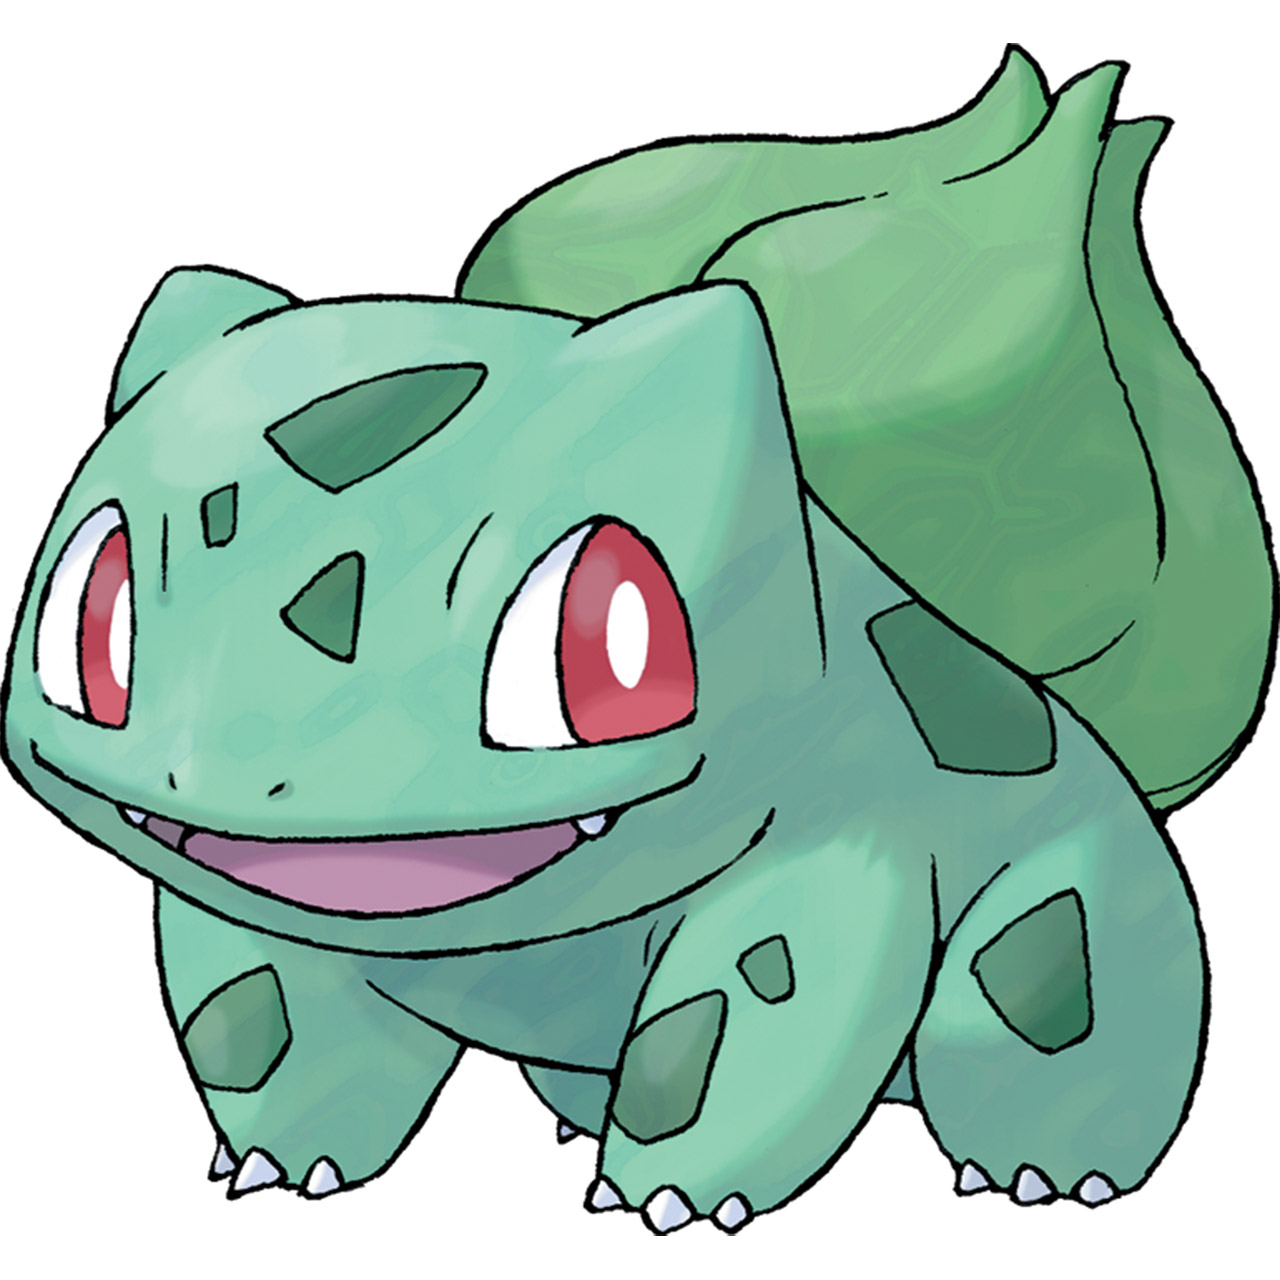

In [41]:
train_dataset[0]["image"]

In [42]:
with accelerator.main_process_first():
    if args.max_train_samples is not None:
        dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))
    # Set the training transforms
    train_dataset = dataset["train"].with_transform(preprocess_train)

In [43]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}


In [44]:
# DataLoaders creation:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size,
    num_workers=args.dataloader_num_workers,
)

In [45]:
for batch in train_dataloader:
    # print(batch)
    print(batch["pixel_values"].shape)
    print(batch["input_ids"].shape)
    break

torch.Size([1, 3, 512, 512])
torch.Size([1, 77])


In [46]:
# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
    num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
)

In [47]:
lr_scheduler.base_lrs

[1e-05]

In [48]:
args.use_ema

False

In [49]:
# Prepare everything with our `accelerator`.
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

if args.use_ema:
    ema_unet.to(accelerator.device)

In [50]:
# For mixed precision training we cast the text_encoder and vae weights to half-precision
# as these models are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move text_encode and vae to gpu and cast to weight_dtype
text_encoder.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [51]:
weight_dtype

torch.float16

In [52]:
text_encoder.device

device(type='cuda', index=0)

In [53]:
text_encoder.dtype

torch.float16

In [54]:
# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

In [55]:
num_update_steps_per_epoch

833

In [56]:
args.num_train_epochs

19

In [57]:
# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    tracker_config = dict(vars(args))
    tracker_config.pop("validation_prompts")
    accelerator.init_trackers(args.tracker_project_name, tracker_config)

train from here

In [58]:
# Train!
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps
print(total_batch_size)

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

06/04/2023 09:53:05 - INFO - __main__ - ***** Running training *****
06/04/2023 09:53:05 - INFO - __main__ -   Num examples = 833
06/04/2023 09:53:05 - INFO - __main__ -   Num Epochs = 19
06/04/2023 09:53:05 - INFO - __main__ -   Instantaneous batch size per device = 1
06/04/2023 09:53:05 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 1
06/04/2023 09:53:05 - INFO - __main__ -   Gradient Accumulation steps = 1
06/04/2023 09:53:05 - INFO - __main__ -   Total optimization steps = 15000


1


In [59]:
print(args.resume_from_checkpoint)

None


In [60]:
# Potentially load in the weights and states from a previous save
if args.resume_from_checkpoint:
    print("resume")
    if args.resume_from_checkpoint != "latest":
        path = os.path.basename(args.resume_from_checkpoint)
    else:
        # Get the most recent checkpoint
        dirs = os.listdir(args.output_dir)
        dirs = [d for d in dirs if d.startswith("checkpoint")]
        dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
        path = dirs[-1] if len(dirs) > 0 else None

    if path is None:
        accelerator.print(
            f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
        )
        args.resume_from_checkpoint = None
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(os.path.join(args.output_dir, path))
        global_step = int(path.split("-")[1])

        resume_global_step = global_step * args.gradient_accumulation_steps
        first_epoch = global_step // num_update_steps_per_epoch
        resume_step = resume_global_step % (num_update_steps_per_epoch * args.gradient_accumulation_steps)


In [61]:
# # Only show the progress bar once on each machine.
# progress_bar = tqdm(range(global_step, args.max_train_steps), disable=not accelerator.is_local_main_process)
# progress_bar.set_description("Steps")

In [62]:
args.noise_offset,args.input_pertubation

(0, 0.1)

In [63]:
print(args.snr_gamma)

None


### Not execution , for test

In [64]:
unet.train()
train_loss = 0.0

for step, batch in enumerate(train_dataloader):
    # print(step)  # 0
    # print(batch)  # dict {'pixel_values','input_ids'}

    with accelerator.accumulate(unet):
        # Convert images to latent space
        latents = vae.encode(batch["pixel_values"].to(weight_dtype)).latent_dist.sample()
        latents = latents * vae.config.scaling_factor
        # print(latents.shape)  # torch.Size([1, 4, 64, 64])

        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        if args.noise_offset:
            # https://www.crosslabs.org//blog/diffusion-with-offset-noise
            noise += args.noise_offset * torch.randn(
                (latents.shape[0], latents.shape[1], 1, 1), device=latents.device
            )
        if args.input_pertubation:
            new_noise = noise + args.input_pertubation * torch.randn_like(noise)
        bsz = latents.shape[0]

        # print(noise.shape)  # torch.Size([1, 4, 64, 64])
        # print(new_noise.shape)  # torch.Size([1, 4, 64, 64])
        # print(bsz)  # 1 batch_size

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()
        # print(timesteps)  # tensor([331], device='cuda:0')

        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        if args.input_pertubation:
            noisy_latents = noise_scheduler.add_noise(latents, new_noise, timesteps)
        else:
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # print(noisy_latents.shape)  # torch.Size([1, 4, 64, 64])

        # Get the text embedding for conditioning
        encoder_hidden_states = text_encoder(batch["input_ids"])[0]
        # print(encoder_hidden_states.shape)  # torch.Size([1, 77, 768])    

        # Get the target for loss depending on the prediction type
        # print(noise_scheduler.config.prediction_type)  # epsilon
        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise  # targer is the noise
        elif noise_scheduler.config.prediction_type == "v_prediction":  # what is this ????!!!!!!!!!
            target = noise_scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

        # Predict the noise residual and compute loss
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
        # print(model_pred.shape)  # torch.Size([1, 4, 64, 64]) predict noise

        if args.snr_gamma is None:  # None
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
        else:
            # Compute loss-weights as per Section 3.4 of https://arxiv.org/abs/2303.09556.
            # Since we predict the noise instead of x_0, the original formulation is slightly changed.
            # This is discussed in Section 4.2 of the same paper.
            snr = compute_snr(timesteps)
            mse_loss_weights = (
                torch.stack([snr, args.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0] / snr
            )
            # We first calculate the original loss. Then we mean over the non-batch dimensions and
            # rebalance the sample-wise losses with their respective loss weights.
            # Finally, we take the mean of the rebalanced loss.
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
            loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
            loss = loss.mean()

            
    break

In [65]:
# Only show the progress bar once on each machine.
progress_bar = tqdm(range(global_step, args.max_train_steps), disable=not accelerator.is_local_main_process)
progress_bar.set_description("Steps")

for epoch in range(first_epoch, args.num_train_epochs):
    unet.train()
    train_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        # Skip steps until we reach the resumed step
        if args.resume_from_checkpoint and epoch == first_epoch and step < resume_step:
            if step % args.gradient_accumulation_steps == 0:
                progress_bar.update(1)
            continue

        with accelerator.accumulate(unet):
            # Convert images to latent space
            latents = vae.encode(batch["pixel_values"].to(weight_dtype)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            if args.noise_offset:
                # https://www.crosslabs.org//blog/diffusion-with-offset-noise
                noise += args.noise_offset * torch.randn(
                    (latents.shape[0], latents.shape[1], 1, 1), device=latents.device
                )
            if args.input_pertubation:
                new_noise = noise + args.input_pertubation * torch.randn_like(noise)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            if args.input_pertubation:
                noisy_latents = noise_scheduler.add_noise(latents, new_noise, timesteps)
            else:
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            # Predict the noise residual and compute loss
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            if args.snr_gamma is None:
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
            else:
                # Compute loss-weights as per Section 3.4 of https://arxiv.org/abs/2303.09556.
                # Since we predict the noise instead of x_0, the original formulation is slightly changed.
                # This is discussed in Section 4.2 of the same paper.
                snr = compute_snr(timesteps)
                mse_loss_weights = (
                    torch.stack([snr, args.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0] / snr
                )
                # We first calculate the original loss. Then we mean over the non-batch dimensions and
                # rebalance the sample-wise losses with their respective loss weights.
                # Finally, we take the mean of the rebalanced loss.
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
                loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                loss = loss.mean()

            # Gather the losses across all processes for logging (if we use distributed training).
            avg_loss = accelerator.gather(loss.repeat(args.train_batch_size)).mean()
            train_loss += avg_loss.item() / args.gradient_accumulation_steps

            # Backpropagate
            accelerator.backward(loss)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            if args.use_ema:
                ema_unet.step(unet.parameters())
            progress_bar.update(1)
            global_step += 1
            accelerator.log({"train_loss": train_loss}, step=global_step)
            train_loss = 0.0

            if global_step % args.checkpointing_steps == 0:
                if accelerator.is_main_process:
                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

        logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)

        if global_step >= args.max_train_steps:
            break

    if accelerator.is_main_process:
        if args.validation_prompts is not None and epoch % args.validation_epochs == 0:
            if args.use_ema:
                # Store the UNet parameters temporarily and load the EMA parameters to perform inference.
                ema_unet.store(unet.parameters())
                ema_unet.copy_to(unet.parameters())
            log_validation(
                vae,
                text_encoder,
                tokenizer,
                unet,
                args,
                accelerator,
                weight_dtype,
                global_step,
            )
            if args.use_ema:
                # Switch back to the original UNet parameters.
                ema_unet.restore(unet.parameters())


  0%|          | 0/15000 [00:00<?, ?it/s]

/remote-home/songtianwei/conda/envs/pytorch2/lib/python3.8/site-packages/xformers/ops/fmha/flash.py:339: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  and inp.query.storage().data_ptr() == inp.key.storage().data_ptr()
06/04/2023 09:56:29 - INFO - accelerate.accelerator - Saving current state to sd-pokemon-model/checkpoint-500
Configuration saved in sd-pokemon-model/checkpoint-500/unet/config.json
Model weights saved in sd-pokemon-model/checkpoint-500/unet/diffusion_pytorch_model.bin
06/04/2023 09:56:47 - INFO - accelerate.checkpointing - Optimizer state saved in sd-pokemon-model/checkpoint-500/optimizer.bin
06/04/2023 09:56:47 - INFO - accelerate.checkpointing - Scheduler state saved in sd-pokemon-model/checkpoint-500/scheduler.bin
06/04/2023 09:56:

In [66]:

# Create the pipeline using the trained modules and save it.
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    unet = accelerator.unwrap_model(unet)
    if args.use_ema:
        ema_unet.copy_to(unet.parameters())

    pipeline = StableDiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        text_encoder=text_encoder,
        vae=vae,
        unet=unet,
        revision=args.revision,
    )
    pipeline.save_pretrained(args.output_dir)

    if args.push_to_hub:
        upload_folder(
            repo_id=repo_id,
            folder_path=args.output_dir,
            commit_message="End of training",
            ignore_patterns=["step_*", "epoch_*"],
        )

accelerator.end_training()

{'requires_safety_checker'} was not found in config. Values will be initialized to default values.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
{'prediction_type'} was not found in config. Values will be initialized to default values.
Configuration saved in sd-pokemon-model/vae/config.json
Model weights saved in sd-pokemon-model/vae/diffusion_pytorch_model.bin
Configuration saved in sd-pokemon-model/unet/config.json
Model weights saved in sd-pokemon-model/unet/diffusion_pytorch_model.bin
Configuration saved in sd-pokemon-model/scheduler/scheduler_config.json
Configuration saved in sd-pokemon-model/model_index.json
